In [1]:
#!pip install pandas openpyxl geopandas matplotlib

import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

## DATACENTER WITH ID "3668" HAS INVERTED LONGITUDE. IS 122, SHOULD BE -122

## Remember to find missing temperatures for hawaii, alaska and district of columbia

In [2]:
data = '../in/datacentermap.csv'

#dc_df = datacenter_dataframe
dc_df = pd.read_csv(data)

# Remove inplace=True
dc_df.drop(['postal', 'link_profile'], axis=1, inplace=True)

mainCountry = 'USA'

mask = dc_df['country'] == mainCountry

dc_df = dc_df[mask]

# Create a GeoDataFrame
dc_gdf = gpd.GeoDataFrame(dc_df, geometry=gpd.points_from_xy(dc_df.longitude, dc_df.latitude))

# Define or identify the coordinate reference system (CRS)
# For the United States, you can use EPSG:4326 (WGS 84) which is commonly used for latitude and longitude coordinates
dc_gdf.crs = "EPSG:4326"

# Loading custom us state shapefile
states_map = gpd.read_file('../in/States_shapefile-shp/States_shapefile.shp')

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_us_states(gdf, data_column=None, plot_points=None, title='INSERT TITLE', colormap='RdYlGn', point_color='black', point_size=3, point_opacity=1, label_states=False):
    fig = plt.figure(figsize=(20, 13))
    fig.suptitle(title, fontsize=24)
    
    # Exclude Hawaii and Alaska when making the initial mainland/contiguous plot
    mainland_us = gdf[~gdf['State_Name'].isin(['HAWAII', 'ALASKA'])]
    # Make new geodataframes for each of the excluded states
    alaska = gdf[gdf['State_Name'] == 'ALASKA']
    hawaii = gdf[gdf['State_Name'] == 'HAWAII']

     # Normalize the color map based on the entire dataset
    if data_column:
        norm = mcolors.Normalize(vmin=gdf[data_column].min(), vmax=gdf[data_column].max())

    # Create a new axis for mainland US
    ax_mainland = fig.add_axes([0, 0.05, 1, 1])  # [x, y, width, height]
    if data_column:
        # Plot mainland US with data column
        mainland_us.plot(column=data_column, cmap=colormap, norm=norm, linewidth=0.8, ax=ax_mainland, edgecolor='0.5', legend=False, missing_kwds={'color': 'lightgrey'})
    else:
        # Plot mainland US without data column (all states in gray)
        mainland_us.plot(color='lightgrey', linewidth=0.8, ax=ax_mainland, edgecolor='0.5')

    # Add Alaska Axis (x, y, width, height)
    akax = fig.add_axes([-0.05, 0.1, 0.3, 0.3])
    if data_column:
        # Plot Alaska with data column
        alaska.plot(column=data_column, cmap=colormap, norm=norm, linewidth=0.8, ax=akax, edgecolor='0.5', missing_kwds={'color': 'lightgrey'})
    else:
        # Plot Alaska without data column (all states in gray)
        alaska.plot(color='lightgrey', linewidth=0.8, ax=akax, edgecolor='0.5')
    akax.set_title('Alaska', fontsize=20)
    
    # Add Hawaii Axis (x, y, width, height)
    hiax = fig.add_axes([0.225, 0.15, 0.15, 0.15])
    if data_column:
        # Plot Hawaii with data column
        hawaii.plot(column=data_column, cmap=colormap, norm=norm, linewidth=0.8, ax=hiax, edgecolor='0.5', missing_kwds={'color': 'lightgrey'})
    else:
        # Plot Hawaii without data column (all states in gray)
        hawaii.plot(color='lightgrey', linewidth=0.8, ax=hiax, edgecolor='0.5')
    hiax.set_title('Hawaii', fontsize=20)

    # Hide all axes borders and labels
    ax_mainland.set_axis_off()
    akax.set_axis_off()
    hiax.set_axis_off()

    # If plotting datacenter locations, make a new geodataframe for datacenter point locations for the mainland, Alaska and Hawaii
    if plot_points is not None:
        # Exclude Hawaii and Alaska when making the initial mainland/contiguous plot
        mainland_us_dc = plot_points[~plot_points['state'].isin(['Hawaii', 'Alaska'])]
        # We only have to make a datacenter gdf for Hawaii, since Alaska doesn't have any datacenters of its own!
        hawaii_dc = plot_points[plot_points['state'] == 'Hawaii']

        # Plot the data points on the mainland map
        mainland_us_dc.plot(ax=ax_mainland, color=point_color, markersize=point_size, alpha=point_opacity)
        
        # Plot the data points on the Hawaii map
        hawaii_dc.plot(ax=hiax, color=point_color, markersize=point_size, alpha=point_opacity)

    if label_states and data_column:
        label_size = 15
        for idx, row in mainland_us.iterrows():
            #s=f"{row[data_column]:g}" converts the label value to an integer if the float is an integer value. e.g. 23.0 = 23
            ax_mainland.text(row.geometry.centroid.x, row.geometry.centroid.y, 
                             s=f"{row[data_column]:g}", horizontalalignment='center', fontsize=label_size)

        if not alaska.empty:
            row = alaska.iloc[0]
            akax.text(row.geometry.centroid.x, row.geometry.centroid.y, 
                      s=f"{row[data_column]:g}", horizontalalignment='center', fontsize=label_size)
        
        if not hawaii.empty:
            row = hawaii.iloc[0]
            hiax.text(row.geometry.centroid.x, row.geometry.centroid.y, 
                      s=f"{row[data_column]:g}", horizontalalignment='center', fontsize=label_size)

    if data_column:
        # Create an axis for the colorbar
        cax = fig.add_axes([0.05, 0.07, 0.9, 0.02])  # [x, y, width, height]
        # Create a ScalarMappable for the colorbar based on the colormap and normalization of the data values.
        sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=gdf[data_column].min(), vmax=gdf[data_column].max()))
        sm._A = []  # This is needed for ScalarMappable
        # Give the colorbar a title named after the data column we are plotting
        cax.set_title(data_column, fontsize=20)
        cax.tick_params(labelsize=20)
        fig.colorbar(sm, cax=cax, orientation='horizontal')

    plt.show()


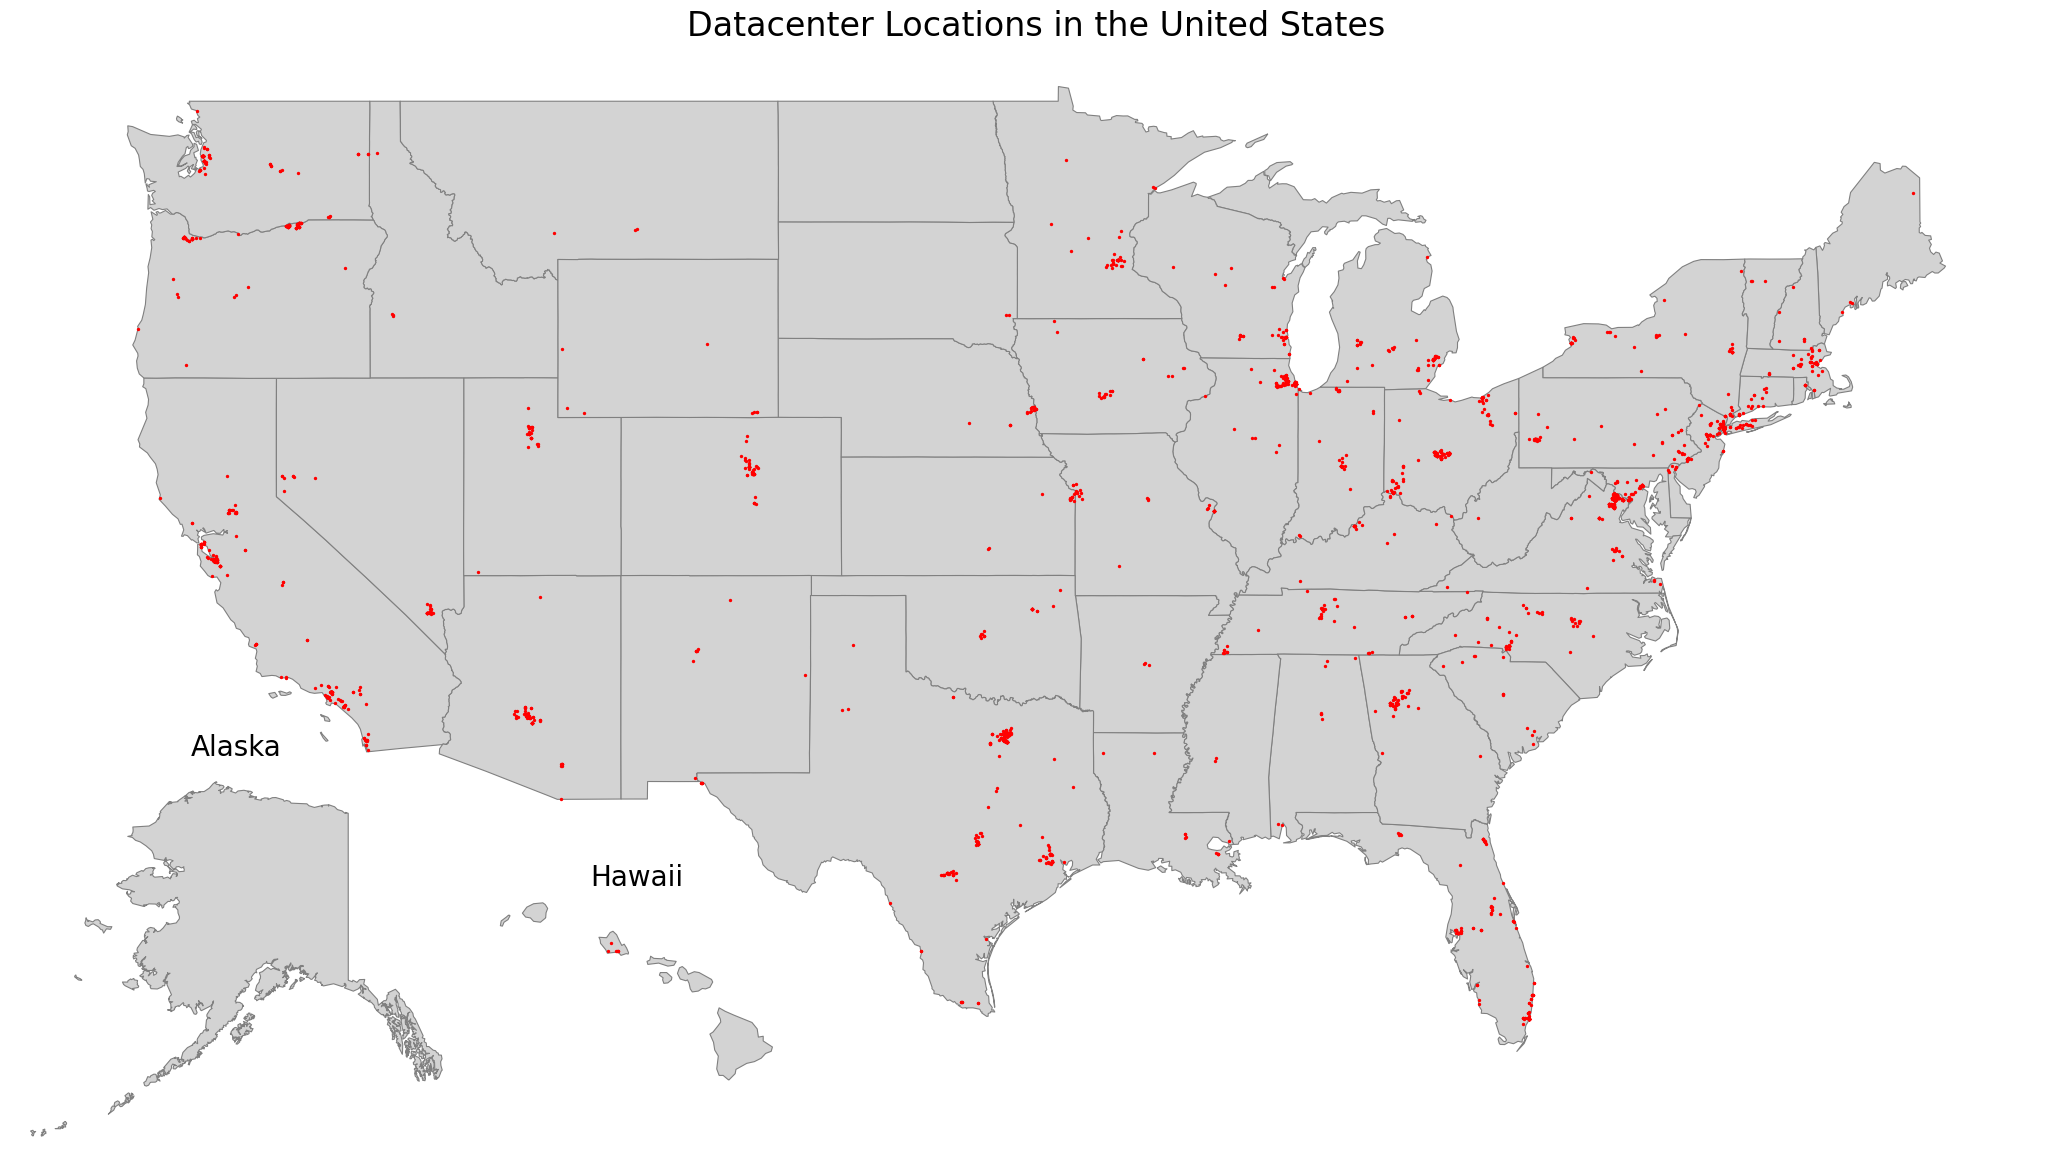

In [4]:
plot_us_states(states_map, 
               title='Datacenter Locations in the United States', 
               plot_points=dc_gdf, 
               point_color='red',
               point_size=2)

In [5]:
def uppercase_df(input_df):
    return input_df.map(lambda x: x.upper() if isinstance(x, str) else x)

In [6]:
state_counts = dc_df['state'].value_counts().reset_index()
# Convert all string values in the dataframe to uppercase since the shapefile uses uppercase state names
state_counts = uppercase_df(state_counts)
state_counts.columns = ['State_Name', 'Datacenter_Count']
state_counts.head()

,State_Name,Datacenter_Count
0,VIRGINIA,311
1,CALIFORNIA,259
2,TEXAS,241
3,OHIO,150
4,NEW YORK,128


In [7]:
# Merge the state counts with the state shapefile map based on state names
merged_data = states_map.merge(state_counts, how='left', on='State_Name')

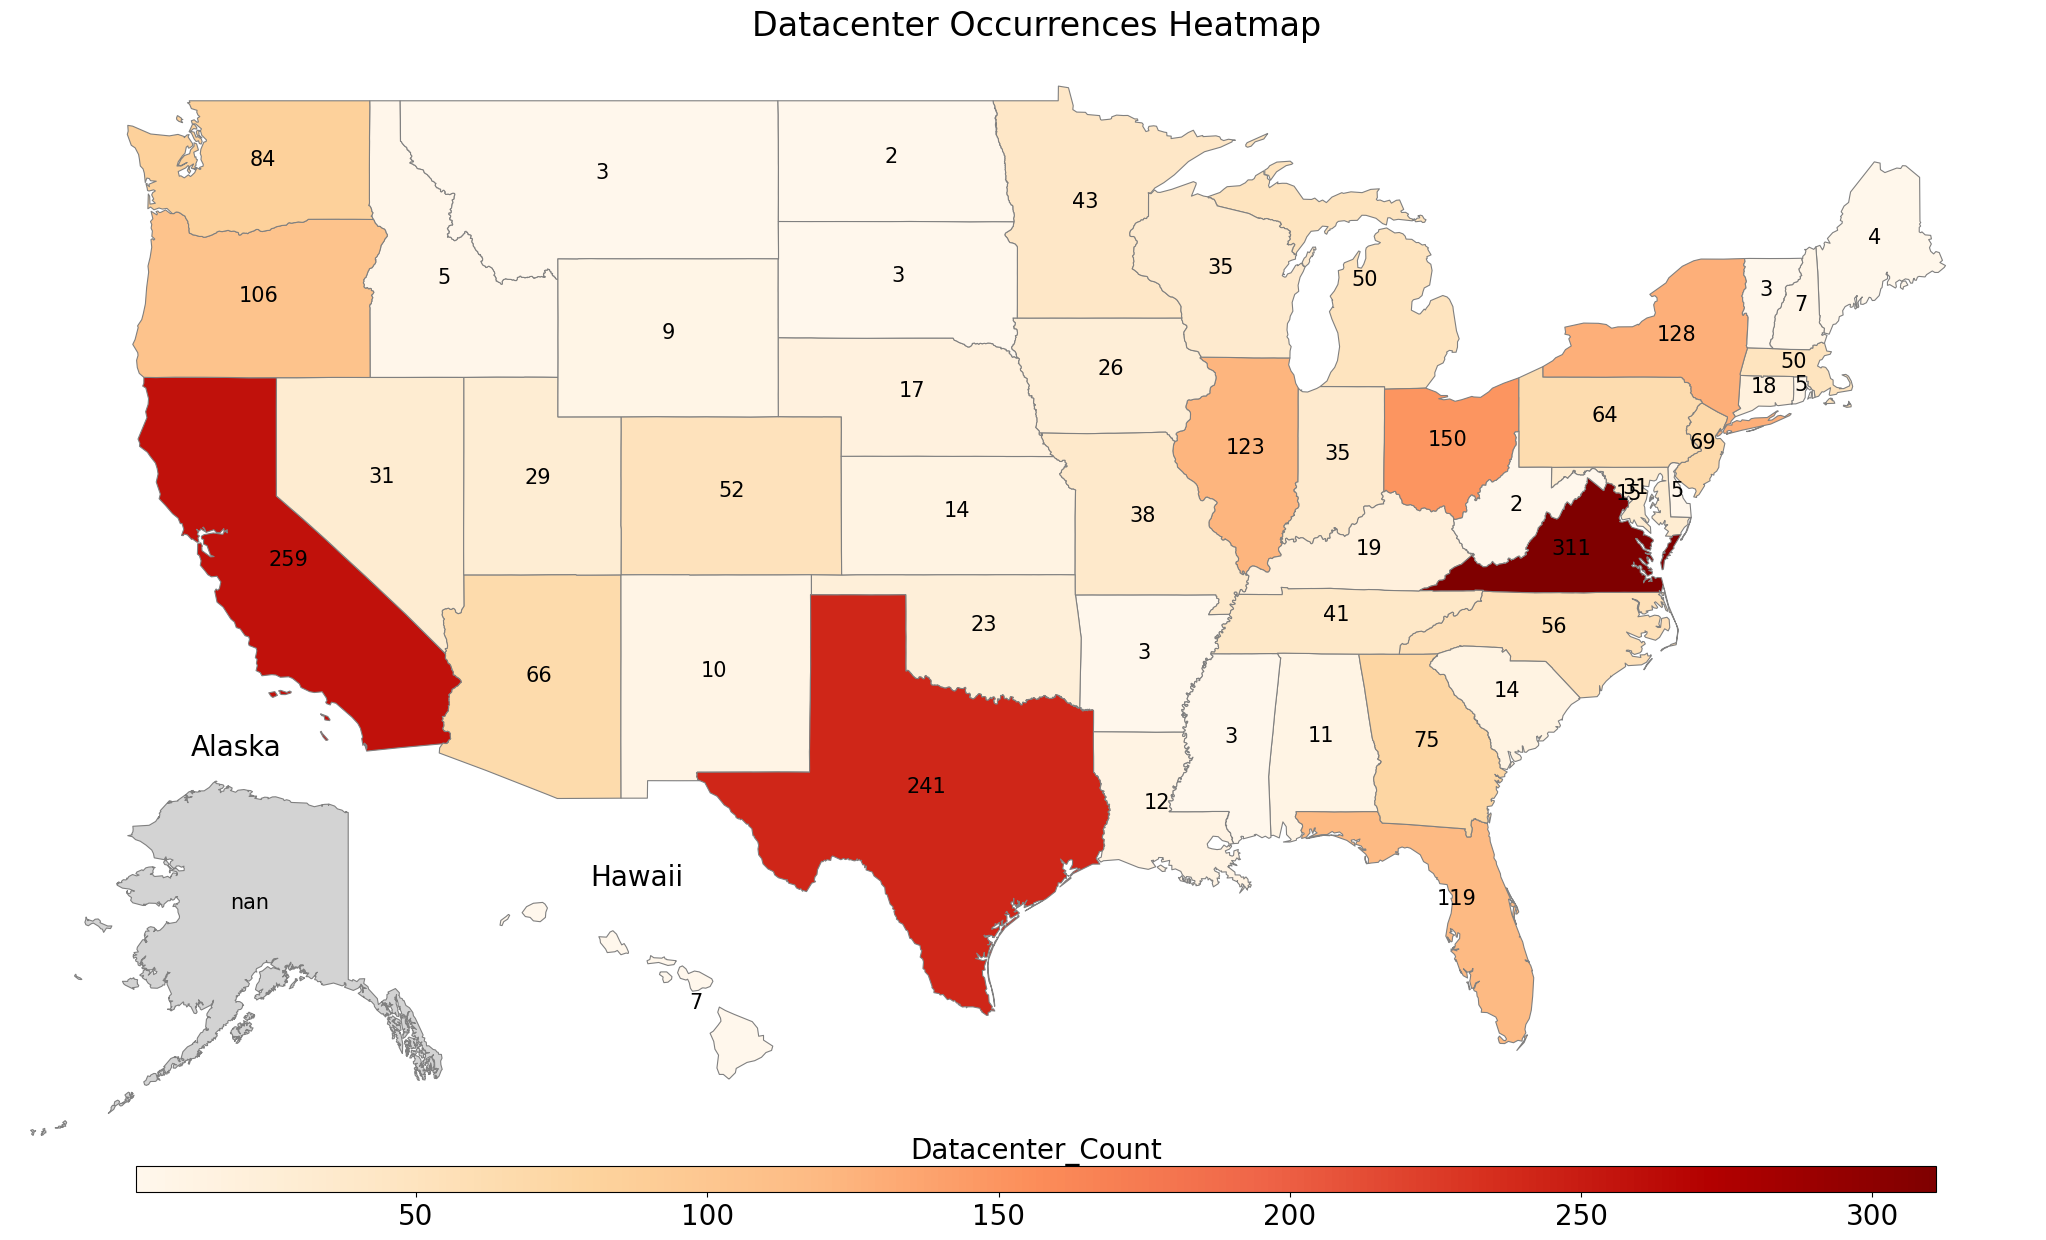

In [8]:
data_column = 'Datacenter_Count'

title = f'Datacenter Occurrences Heatmap'

plot_us_states(merged_data, data_column, title=title, colormap='OrRd', label_states=True)

In [9]:
power_df = pd.read_excel('../in/avgprice_annual.xlsx', skiprows=1)

#only keeping power prices from 2020
power_df = power_df[power_df['Year'] == 2020]

#only keeping "total electric industry" as the industry sector as its the only one that has all 51 states.
power_df = power_df[power_df['Industry Sector Category'] == 'Total Electric Industry']


In [10]:
#Add the power prices to the merged data 
merged_data = merged_data.merge(power_df, how='left', left_on='State_Code', right_on='State')

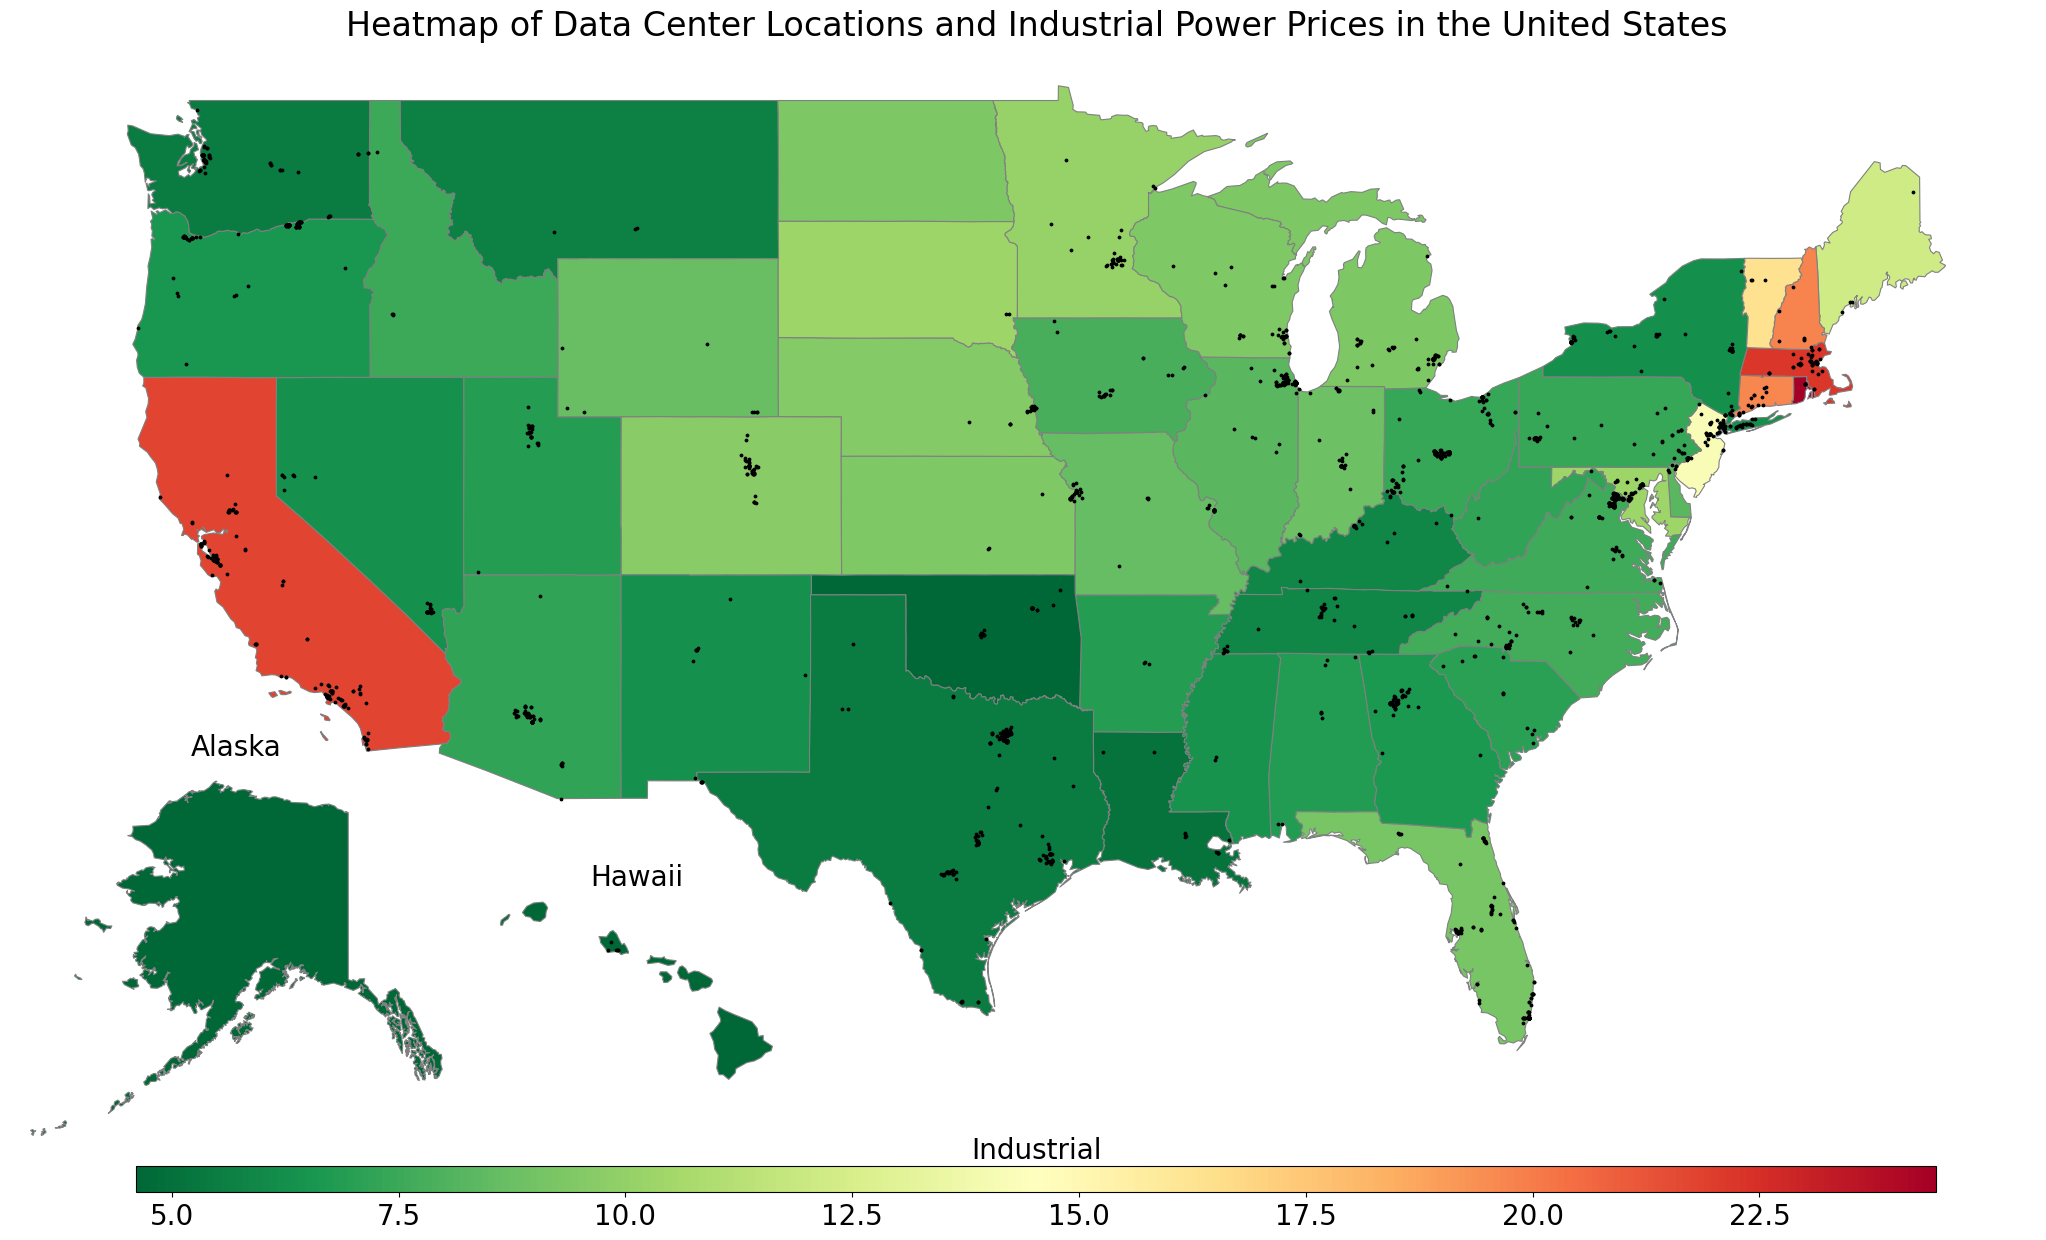

In [11]:
power_sector = 'Industrial'

title = f'Heatmap of Data Center Locations and {power_sector} Power Prices in the United States'

plot_us_states(merged_data, power_sector, plot_points=dc_gdf, title=title, colormap='RdYlGn_r')

In [12]:
internet_df = pd.read_csv('../in/average-internet-speed-by-state-2024.csv')

internet_df = uppercase_df(internet_df)

internet_df.rename(columns={'state': 'State_Name'}, inplace=True)

merged_data = merged_data.merge(internet_df, how='left', on='State_Name')

In [ ]:
merged_data

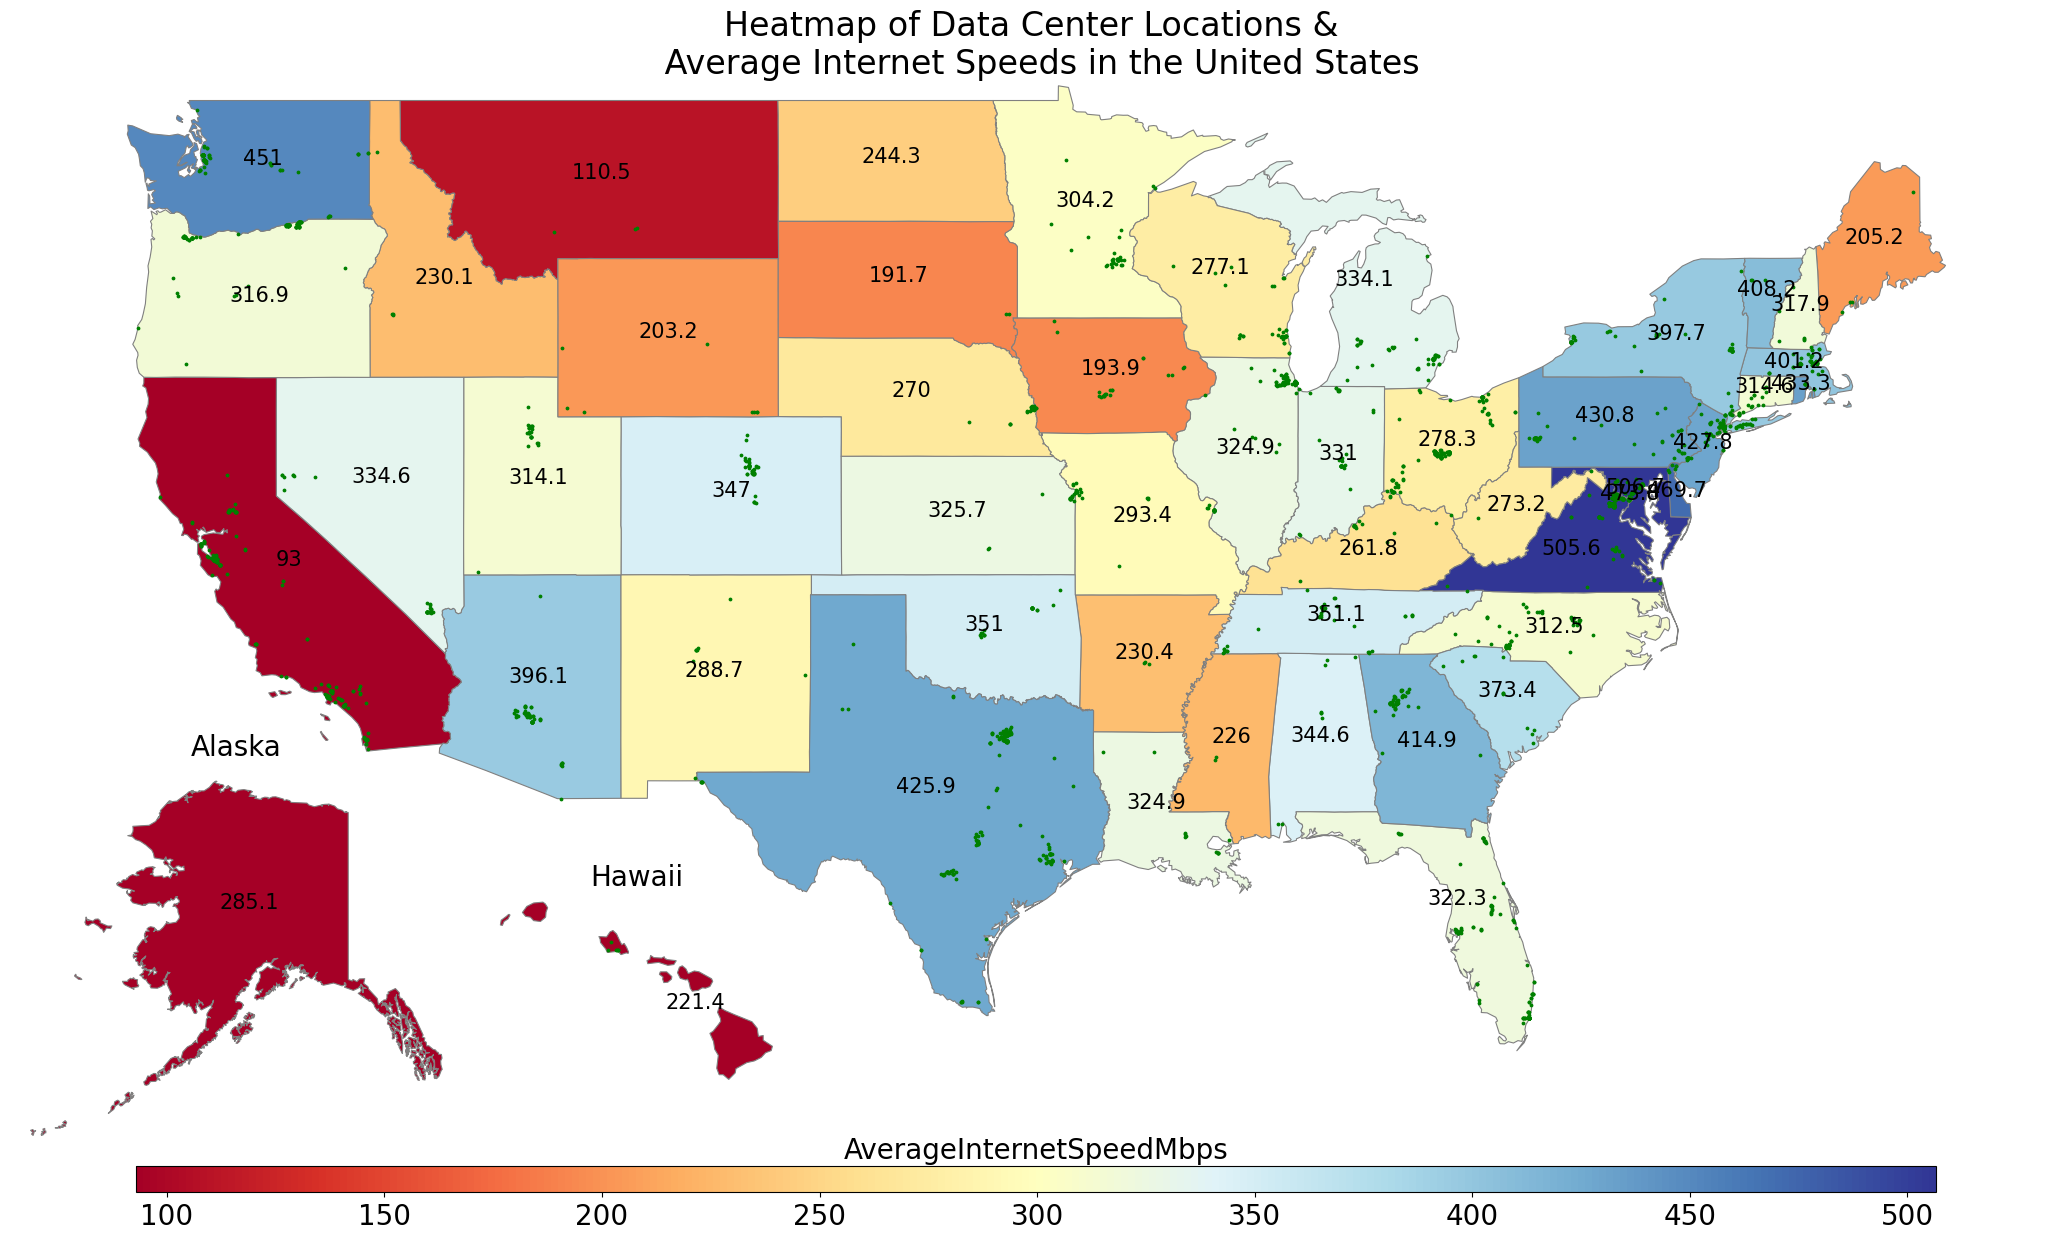

In [19]:
data_column = 'AverageInternetSpeedMbps'

title = f'Heatmap of Data Center Locations & \n Average Internet Speeds in the United States'

plot_us_states(merged_data, data_column, plot_points=dc_gdf, title=title, colormap='RdYlBu', label_states=True, point_color='green')

## State temperatures

First, we import the average annual temperature by states for 2023.

In [ ]:
state_temp_file = os.path.join('..','in','state_temp.csv')
state_temp = pd.read_csv(state_temp_file, skiprows=4)
state_temp.head()

Then, we rename the "name" colum to "State_Name" and the "value" column to "temperature".

In [ ]:
state_temp.rename(columns={'Name' : 'State_Name', 'Value' : 'temperature'}, inplace=True)

state_temp = state_temp[['State_Name','temperature']]

state_temp.head()

Then we convert the temperatures from fahrenheit to celsius by applying a custom funtion to the column.

In [ ]:
def fahrenheit_to_celsius(fahrenheit):
    """
    Convert Fahrenheit to Celsius.

    Parameters:
    fahrenheit (float): Temperature in Fahrenheit.

    Returns:
    float: Temperature in Celsius.
    """
    celsius = (fahrenheit - 32) * 5.0/9.0
    return celsius

state_temp['temperature'] = state_temp['temperature'].apply(fahrenheit_to_celsius)

state_temp.head()

In [ ]:
#converting to uppercase again, because thats what the merged_data shapefile uses for state names.
state_temp = uppercase_df(state_temp)

merged_data = merged_data.merge(state_temp, how='left', on='State_Name')

merged_data.head()


In [ ]:
data_column = 'temperature'

title = f'Heatmap of average annual temperature (°C) & \n Datacenter locations in the united states'

plot_us_states(merged_data, data_column, plot_points=dc_gdf, title=title, colormap='RdYlBu_r')

## Humidity

In [ ]:
humidity_file = os.path.join('..','in','most-humid-states-2024.csv')
state_humidity = pd.read_csv(humidity_file)
state_humidity.head()

Renaming the columns

In [ ]:
state_humidity.rename(columns={'state' : 'State_Name',
                               'MostHumidStatesAverageRelativeHumidity' : 'relative_humidity',
                               'MostHumidStatesAverageDewPointF' : 'avg_dewpoint'},
                               inplace=True)
state_humidity.head()

Converting State_Name column to uppercase, and converting dewpoint from fahrenheit to celsius

In [ ]:
state_humidity = uppercase_df(state_humidity)

state_humidity['avg_dewpoint'] = state_humidity['avg_dewpoint'].apply(fahrenheit_to_celsius)

state_humidity.head()

In [ ]:
merged_data = merged_data.merge(state_humidity, how='left', on='State_Name')

In [ ]:
data_column = 'relative_humidity'

title = f'Heatmap of average annual relative humidity (%) & \n Datacenter locations in the united states'

plot_us_states(merged_data, data_column, plot_points=dc_gdf, title=title, colormap='RdYlGn')